<a href="https://colab.research.google.com/github/divyalaldinani/Deep-Learning-in-TensorFlow/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Creating models on all 101 food categories: 10% training data

In [26]:
!wget https://raw.githubusercontent.com/divyalaldinani/Deep-Learning-in-TensorFlow/refs/heads/main/extras/helper_functions.py

--2025-01-25 14:17:34--  https://raw.githubusercontent.com/divyalaldinani/Deep-Learning-in-TensorFlow/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4090 (4.0K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   3.99K  --.-KB/s    in 0s      

2025-01-25 14:17:34 (63.5 MB/s) - ‘helper_functions.py.1’ saved [4090/4090]



In [3]:
from helper_functions import prep_and_load_file, plot_confusion_matrix, pred_and_plot, plot_loss_curves, unzip_folder, view_random_image, walk_through_directory, view_random_image_and_augmented, create_tensorboard_callback1

In [4]:
!nvidia-smi

Sat Jan 25 13:58:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Downloading and preprocessing the data

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-25 13:58:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   158MB/s    in 10s     

2025-01-25 13:58:14 (155 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_folder('101_food_classes_10_percent.zip')

In [7]:
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [8]:
walk_through_directory('101_food_classes_10_percent')

2 directories and 0 files in 101_food_classes_10_percent
101 directories and 0 files in 101_food_classes_10_percent/train
0 directories and 75 files in 101_food_classes_10_percent/train/pizza
0 directories and 75 files in 101_food_classes_10_percent/train/french_toast
0 directories and 75 files in 101_food_classes_10_percent/train/shrimp_and_grits
0 directories and 75 files in 101_food_classes_10_percent/train/pad_thai
0 directories and 75 files in 101_food_classes_10_percent/train/chocolate_mousse
0 directories and 75 files in 101_food_classes_10_percent/train/grilled_cheese_sandwich
0 directories and 75 files in 101_food_classes_10_percent/train/churros
0 directories and 75 files in 101_food_classes_10_percent/train/hot_dog
0 directories and 75 files in 101_food_classes_10_percent/train/tiramisu
0 directories and 75 files in 101_food_classes_10_percent/train/frozen_yogurt
0 directories and 75 files in 101_food_classes_10_percent/train/paella
0 directories and 75 files in 101_food_cla

### Creating input data pipelines

In [9]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE,
                                                                            seed = 42) # convert images to this dim

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle = False) # defaults to True, set to False as shuffling doesnt help and you want to test on same data all times, to get a better criteria for comparision


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Training a Model on 101 Categories for 10% of training data

In [10]:
checkpoint_path = 'model_0_checkpoints_weights/ckpt/ceckpoint.weights.h5'
# to save model's weights for further use

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                         save_weights_only=True,
                                         monitor='val_accuracy', # save the model that gets best val accuracy
                                         save_best_only=True)


In [11]:

# from tensorflow.keras.layers.experimental import preprocessing


In [12]:
base_model = tf.keras.applications.MobileNetV3Small(include_top=False)

base_model.trainable = False

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
], name = 'data_augmentation')

inputs = layers.Input(shape=(224, 224, 3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation='softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_0 = model.fit(train_data_10_percent,
                      validation_data=test_data,
                      epochs=5,
                      callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 108s 414ms/step - accuracy: 0.0625 - loss: 4.4624 - val_accuracy: 0.2811 - val_loss: 3.0926
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 153s 483ms/step - accuracy: 0.2755 - loss: 3.1235 - val_accuracy: 0.3725 - val_loss: 2.5930
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 96s 288ms/step - accuracy: 0.3695 - loss: 2.6961 - val_accuracy: 0.4059 - val_loss: 2.3754
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 278ms/step - accuracy: 0.4110 - loss: 2.4857 - val_accuracy: 0.4386 - val_loss: 2.2449
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 265ms/step - accuracy: 0.4442 - loss: 2.3132 - val_accuracy: 0.4611 - val_loss: 2.1432


In [14]:
inputs

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer>

In [15]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.4299 - loss: 2.3040


[2.143155574798584, 0.461108922958374]

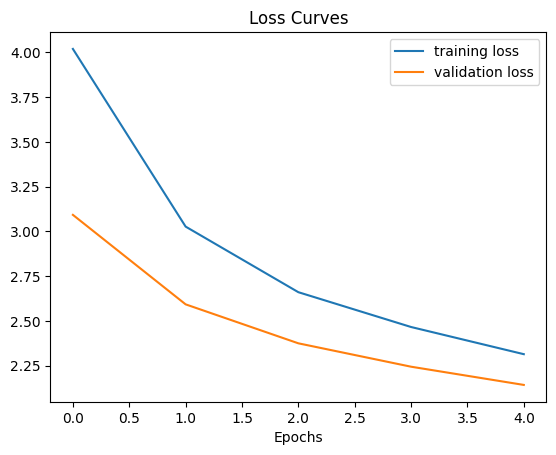

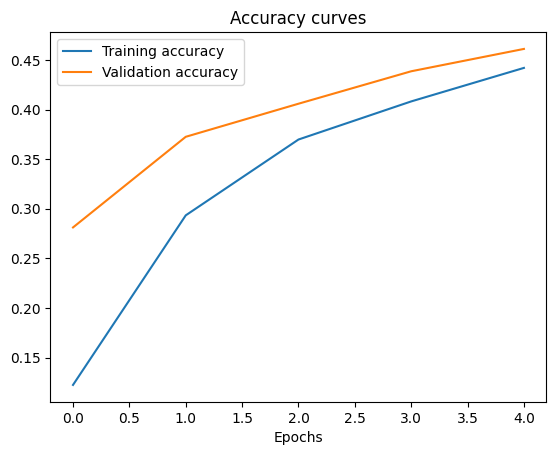

In [16]:
plot_loss_curves(history_0)

#### Fine-tuning

In [17]:
# Initially,
# base_model = tf.keras.applications.MobileNetV3Small(include_top=False)

# base_model.trainable = False

base_model.trainable=True
for layer in base_model.layers:
    print(f"{layer.name} {layer.trainable}")

input_layer True
rescaling True
conv True
conv_bn True
activation True
expanded_conv_depthwise_pad True
expanded_conv_depthwise True
expanded_conv_depthwise_bn True
re_lu True
expanded_conv_squeeze_excite_avg_pool True
expanded_conv_squeeze_excite_conv True
expanded_conv_squeeze_excite_relu True
expanded_conv_squeeze_excite_conv_1 True
re_lu_1 True
expanded_conv_squeeze_excite_mul True
expanded_conv_project True
expanded_conv_project_bn True
expanded_conv_1_expand True
expanded_conv_1_expand_bn True
re_lu_2 True
expanded_conv_1_depthwise_pad True
expanded_conv_1_depthwise True
expanded_conv_1_depthwise_bn True
re_lu_3 True
expanded_conv_1_project True
expanded_conv_1_project_bn True
expanded_conv_2_expand True
expanded_conv_2_expand_bn True
re_lu_4 True
expanded_conv_2_depthwise True
expanded_conv_2_depthwise_bn True
re_lu_5 True
expanded_conv_2_project True
expanded_conv_2_project_bn True
expanded_conv_2_add True
expanded_conv_3_expand True
expanded_conv_3_expand_bn True
activation_1 

In [18]:
# only train/unfreeze last 5 layers(towards output)
for layer in base_model.layers[:-5]:
    layer.trainable = False

for layer in base_model.layers:
    print(f"Layer: {layer} Trainable? : {layer.trainable}")

Layer: <InputLayer name=input_layer, built=True> Trainable? : False
Layer: <Rescaling name=rescaling, built=True> Trainable? : False
Layer: <Conv2D name=conv, built=True> Trainable? : False
Layer: <BatchNormalization name=conv_bn, built=True> Trainable? : False
Layer: <Activation name=activation, built=True> Trainable? : False
Layer: <ZeroPadding2D name=expanded_conv_depthwise_pad, built=True> Trainable? : False
Layer: <DepthwiseConv2D name=expanded_conv_depthwise, built=True> Trainable? : False
Layer: <BatchNormalization name=expanded_conv_depthwise_bn, built=True> Trainable? : False
Layer: <ReLU name=re_lu, built=True> Trainable? : False
Layer: <GlobalAveragePooling2D name=expanded_conv_squeeze_excite_avg_pool, built=True> Trainable? : False
Layer: <Conv2D name=expanded_conv_squeeze_excite_conv, built=True> Trainable? : False
Layer: <ReLU name=expanded_conv_squeeze_excite_relu, built=True> Trainable? : False
Layer: <Conv2D name=expanded_conv_squeeze_excite_conv_1, built=True> Trainab

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.load_weights(checkpoint_path)
history_1 = model.fit(train_data_10_percent,
          validation_data=test_data,
          epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 276ms/step - accuracy: 0.4156 - loss: 2.3956 - val_accuracy: 0.4470 - val_loss: 2.1728
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 269ms/step - accuracy: 0.4871 - loss: 2.0453 - val_accuracy: 0.4794 - val_loss: 2.0468
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 121s 433ms/step - accuracy: 0.5155 - loss: 1.9126 - val_accuracy: 0.4897 - val_loss: 1.9970
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 103s 266ms/step - accuracy: 0.5212 - loss: 1.8386 - val_accuracy: 0.5072 - val_loss: 1.9311
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 63s 264ms/step - accuracy: 0.5460 - loss: 1.7574 - val_accuracy: 0.5067 - val_loss: 1.9185


In [20]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.4742 - loss: 2.0568


[1.9185316562652588, 0.5066930651664734]

In [21]:
import matplotlib.pyplot as plt
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


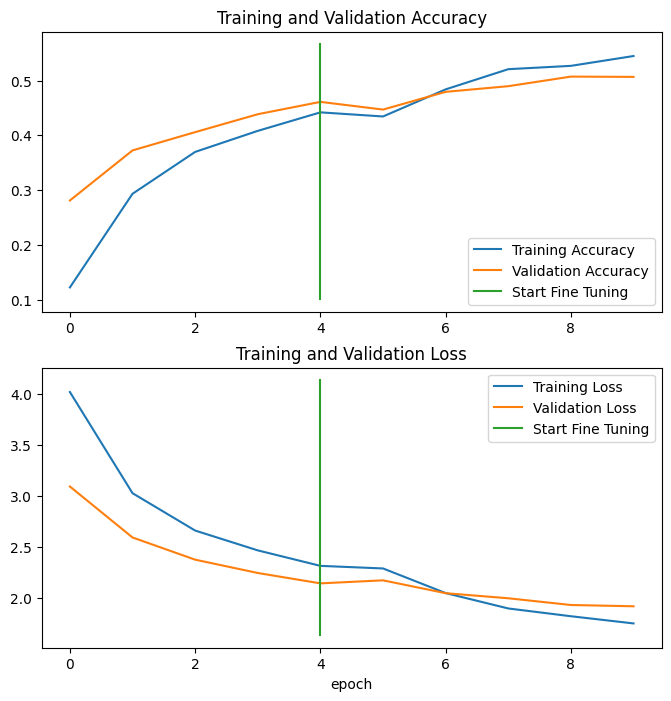

In [22]:
compare_historys(original_history=history_0,
                 new_history=history_1,
                 initial_epochs=5)

### Saving this model

In [23]:
import tensorflow as tf
from google.colab import drive
# drive.mount('/content/drive')
import os

# Create the directory if it doesn't exist
os.makedirs('/content/drive/MyDrive/tensorflow_course', exist_ok=True)

model.save('/content/drive/MyDrive/tensorflow_course/101_food_class_10_percent_model_1.keras')


In [24]:
saved_model_path = '/content/drive/MyDrive/tensorflow_course/101_food_class_10_percent_model_1.keras'

model = tf.keras.models.load_model(saved_model_path)

In [27]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.4742 - loss: 2.0568


[1.9185316562652588, 0.5066930651664734]

In [28]:
preds = model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step


In [31]:
preds

array([[5.4596916e-02, 4.3475570e-04, 3.1256851e-02, ..., 3.6000274e-05,
        4.7112018e-04, 1.5652466e-03],
       [6.6880703e-02, 2.2628412e-07, 1.8586353e-03, ..., 1.3152965e-03,
        4.4845829e-06, 7.3528249e-06],
       [1.3552515e-01, 1.9310431e-03, 2.7104580e-01, ..., 4.7177105e-04,
        1.3867795e-04, 1.8136069e-04],
       ...,
       [1.7395227e-04, 6.8852142e-03, 3.1347068e-07, ..., 9.8477828e-04,
        1.4620409e-03, 3.2383215e-01],
       [9.6088238e-03, 1.9239975e-02, 1.2310313e-03, ..., 7.9885934e-04,
        7.8589801e-05, 4.0641803e-02],
       [3.8783515e-03, 3.8366234e-03, 1.2160097e-05, ..., 1.1613209e-05,
        2.4450483e-04, 1.3268617e-02]], dtype=float32)

In [32]:
preds.shape # probability of an image belonging to each of  101 classes

(25250, 101)

In [33]:
preds[:10]

array([[5.4596916e-02, 4.3475570e-04, 3.1256851e-02, ..., 3.6000274e-05,
        4.7112018e-04, 1.5652466e-03],
       [6.6880703e-02, 2.2628412e-07, 1.8586353e-03, ..., 1.3152965e-03,
        4.4845829e-06, 7.3528249e-06],
       [1.3552515e-01, 1.9310431e-03, 2.7104580e-01, ..., 4.7177105e-04,
        1.3867795e-04, 1.8136069e-04],
       ...,
       [1.3527905e-02, 7.1912127e-06, 8.3770389e-03, ..., 6.3216805e-02,
        1.0489339e-04, 1.2968710e-05],
       [7.8199781e-02, 4.0417293e-04, 7.4625134e-02, ..., 1.1035168e-04,
        8.2350883e-04, 6.7680550e-05],
       [1.0280407e-01, 1.7121577e-06, 1.3106429e-03, ..., 7.6198846e-04,
        2.0803283e-05, 2.8184959e-04]], dtype=float32)

In [73]:
pred_classes = preds.argmax(axis=1) # takes max in inner 1st dim -> inner most in 2d vector
pred_classes

array([ 85,  24,   8, ..., 100,  68,  68])

In [74]:
pred_classes.shape

(25250,)

In [75]:
y_labels = []
import numpy as np


for images, labels in test_data.take(1): # take 1 batch of data to checkout
    print(labels)
    print(images)


for images, labels in test_data:
    y_labels.extend(np.argmax(labels, axis=1).reshape(-1,))

y_labels = np.array(y_labels)


tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(32, 101), dtype=float32)
tf.Tensor(
[[[[ 99.09694   119.09694   189.63776  ]
   [ 76.87755    94.89796   161.13776  ]
   [ 59.33673    71.63776   132.48979  ]
   ...
   [203.        216.        251.       ]
   [203.97449   212.97449   251.97449  ]
   [203.        212.        251.       ]]

  [[112.234695  135.09694   205.14285  ]
   [ 95.36224   114.29591   182.43367  ]
   [ 69.44388    84.44388   146.08673  ]
   ...
   [203.21426   215.42853   252.78574  ]
   [202.92856   214.92856   252.92856  ]
   [202.        214.        254.       ]]

  [[127.56632   152.20918   221.99489  ]
   [105.484695  128.5153    196.5      ]
   [ 82.97449   100.668365  165.94897  ]
   ...
   [202.78572   214.78572   253.12245  ]
   [200.72958   214.51529   254.15816  ]
   [199.78572   212.78572   255.       ]]

  ...

  [[148.2194    1

In [76]:
y_labels.shape

(25250,)

In [77]:
y_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [78]:
from sklearn.metrics import accuracy_score

sk_learn_accuracy = accuracy_score(y_labels, pred_classes)
sk_learn_accuracy

0.5066930693069307

In [88]:
classes = test_data.class_names

In [85]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [89]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=classes,figsize=(100, 100), text_size=25, norm=False, savefig=False)